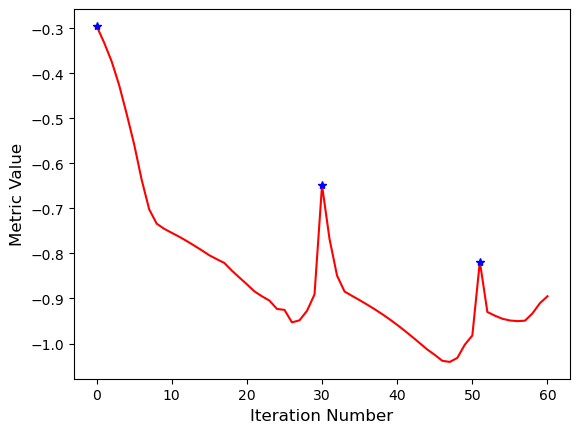

Final metric value: -0.904467572600301
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 10.


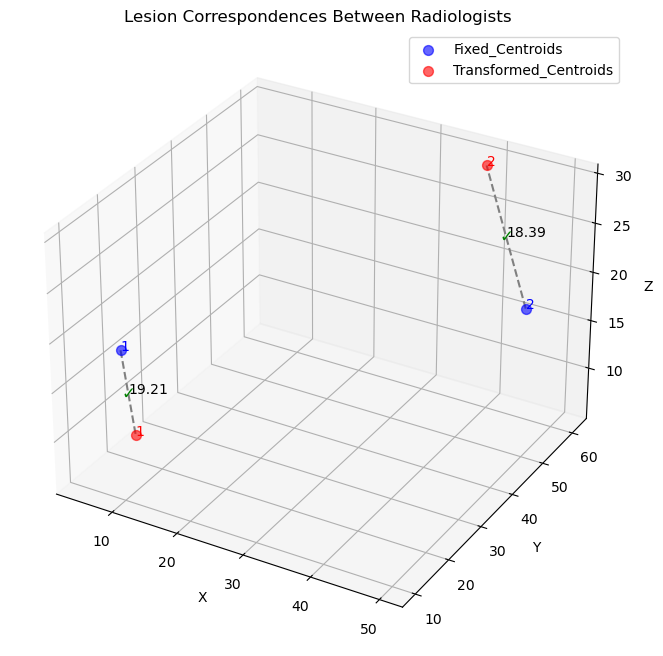

In [9]:
import sys
sys.path.append("../ralmac")
from registration import *
from correspondence_csv_input import *
from transform_coordinates import *
from merge_dataframe import *
from phantominator import shepp_logan
import warnings
import scipy
import numpy as np
import SimpleITK as sitk
import pandas as pd

# Filter out UserWarning and FutureWarning temporarily
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# size and pixel spacing of the phantom
phantom_shape = (128, 128, 128)
spacing = (1.,) * 3

# create shepp logan test phantom
phantom = shepp_logan(phantom_shape)

def insert_lesion(x,c,r):
    """
    Insert a simulated lesion into the phantom.

    Parameters:
        x (ndarray): The input phantom.
        c (tuple): The coordinates (x, y, z) of the lesion.
        r (int): The radius of the lesion.

    Returns:
        ndarray: The phantom with the inserted lesion.
    """
    [xx,yy,zz] = np.meshgrid(*[np.arange(y) for y in x.shape])
    lesion = np.zeros(x.shape)
    lesion[((xx-c[0])**2+(yy-c[1])**2+(zz-c[2])**2)<r**2] = 0.5
    return x+lesion

lesion_coords = [(10, 10, 20), (50, 50, 20)] 
lesion_radii = [3, 8]

for ll, lesions in enumerate(lesion_coords):
    phantom = insert_lesion(phantom,lesion_coords[ll],lesion_radii[ll])

# Convert phantom to SimpleITK format
fixed_image = sitk.GetImageFromArray(phantom)
fixed_image.SetSpacing(spacing)

def transform_phantom(phantom, rotation_angle, translation):
    """
    Apply rotation and translation to the phantom.

    Parameters:
        phantom (ndarray): The input phantom.
        rotation_angle (float): The rotation angle in degrees.
        translation (tuple): The translation vector (z, y, x).

    Returns:
        ndarray: The transformed phantom.
    """
    rotated = scipy.ndimage.rotate(phantom, rotation_angle, axes=(0, 1), reshape=False)
    translated = scipy.ndimage.shift(rotated, translation)
    return translated

# Apply transformation to the phantom
rotation_angle = 30  # degrees
translation = (0, 10, 15)  # z, y, x
transformed_phantom = transform_phantom(phantom, rotation_angle, translation)

# Convert transformed phantom to SimpleITK format
def array_to_sitk(x):
    x_sitk = sitk.GetImageFromArray(x)
    x_sitk.SetOrigin((0, 0, 0))
    x_sitk.SetSpacing(spacing)
    return x_sitk

moving_image = array_to_sitk(transformed_phantom)

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta degrees.
    """
    theta = np.radians(theta)
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

# Apply rotation and translation to lesion coordinates
transformed_lesion_coords = []
rotation_matrix_x = rotation_matrix([1, 0, 0], rotation_angle)
rotation_matrix_y = rotation_matrix([0, 1, 0], rotation_angle)

for coord in lesion_coords:
    rotated_coord = np.dot(rotation_matrix_x, np.dot(rotation_matrix_y, coord))
    transformed_coord = rotated_coord + translation
    transformed_lesion_coords.append(tuple(transformed_coord))

print("Transformed Lesion Coordinates in the Moving Image:")
for i, coord in enumerate(transformed_lesion_coords):
    print(f"Lesion {i + 1}: {coord}")

def save_lesion_coordinates(lesion_coords, lesion_index, filename):
    """
    Save lesion coordinates to a CSV file.

    Parameters:
        lesion_coords (list of tuples): List of lesion coordinates (x, y, z).
        lesion_index (list of int): List of lesion indices.
        filename (str): The filename for the CSV file.
    """
    df = pd.DataFrame({'x': [coord[0] for coord in lesion_coords],
                       'y': [coord[1] for coord in lesion_coords],
                       'z': [coord[2] for coord in lesion_coords],
                       'Index': [str(index) for index in lesion_index]})
    df.to_csv(filename, index=False)

# Filenames
filename_fixed = 'fixed_coordinates.csv'
filename_moving = 'moving_coordinates.csv'

# Save the fixed lesion coordinates
save_lesion_coordinates(lesion_coords, lesion_index, filename_fixed)

# Save the moving lesion coordinates
save_lesion_coordinates(transformed_lesion_coords, lesion_index, filename_moving)

moving_resampled, [init_transform, final_transform] = registration_3d_rigid_series(fixed_image, moving_image)

final_transform_1 = final_transform.GetInverse()

registered_coordinates = create_transformed_dataframe(filename_moving, final_transform_1)

def save_transformed_dataframe(transformed_df, output_file):
    """Saves the transformed DataFrame to a CSV file."""
    transformed_df.to_csv(output_file, index=False)

save_transformed_dataframe(registered_coordinates, 'registered_coordinates.csv')

threshold = 30
filename_registered = 'registered_coordinates.csv'
correspondences, unmatched_names_df1, unmatched_names_df2 = process_lesion_timepoints(filename_fixed, filename_registered, threshold)

plot_lesion_correspondences_timepoints(filename_fixed, filename_registered)

final_df = create_final_dataframe_timepoints(correspondences, unmatched_names_df1, unmatched_names_df2, filename_fixed, filename_registered)

df_transformed = merge_indices(final_df)

df_transformed.to_csv('correspondence_indices.csv', index=False)
